In [1]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import re, random, pickle, glob, os, difflib
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from utils import *

In [2]:
print(tf.__version__)

2.3.1


In [3]:
train_root = 'train/'
test_root = 'test/'
model_root = 'models/'
train_set = ['x10_reads.fa']

In [4]:
df = read_fasta(train_root + train_set[0])
train_reads = np.array(seqs2onehot(np.array(df.seqs)))

In [5]:
train_reads = np.expand_dims(train_reads, -1)

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        output = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return output

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 150 * 5
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [8]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [12]:
latent_dim = 16
width = 512
input_size = (150,5,1)
filter_size = (5, 5)
epochs = 10
batch_size = 256

beta = 3

In [13]:
ckpt_num = 'betavae'
ckpt_dir = os.path.join(model_root, ckpt_num, '')
if (os.path.isdir(ckpt_dir) == False):
    os.mkdir(os.path.join(ckpt_dir, ''))
callbacks = [keras.callbacks.ModelCheckpoint(ckpt_dir+"/save_at_{epoch}.h5")]

In [14]:
with strategy.scope():
    encoder_inputs = keras.Input(shape=input_size)
    x = layers.Conv2D(width, filter_size, activation="relu", strides=(2,1), padding="same")(encoder_inputs)
    x = layers.Conv2D(width, filter_size, activation="relu", strides=(2,1), padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(width, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    print(encoder.summary())
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(38 * 5 * width, activation="relu")(latent_inputs)
    x = layers.Reshape((38, 5, width))(x)

    x = layers.Conv2DTranspose(width, filter_size, activation="relu", strides=(2, 1), padding="same")(x)
    x = layers.Cropping2D(cropping=((0, 1), (0, 0)))(x)

    x = layers.Conv2DTranspose(width, filter_size, activation="relu", strides=(2, 1), padding="same")(x)
    decoder_outputs = layers.Conv2D(1, filter_size, activation="sigmoid", padding="same")(x)

    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    print(decoder.summary())
    
    vae = VAE(encoder, decoder, beta)
    vae.compile(optimizer=keras.optimizers.Adam(0.001))

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 5, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 75, 5, 512)   13312       input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 38, 5, 512)   6554112     conv2d_3[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 97280)        0           conv2d_4[0][0]                   
____________________________________________________________________________________________

In [15]:
history = vae.fit(train_reads, epochs=epochs, batch_size=batch_size, verbose =1, callbacks = callbacks)

Epoch 1/10
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
663/663 [==============================] - 161s 242ms/step - loss: 402.2105 - reconstruction_loss: 391.6416 - kl_loss: 3.5230
Epoch 2/10
663/663 [==============================] - 160s 242ms/step - loss: 338.7422 - reconstruction_loss: 338.7422 - kl_loss: 7.9969e-09
Epoch 3/10
663/663 [==============================] - 160s 242ms/step - loss: 335.8826 - reconstruction_loss: 335.8826 - kl_loss: 4.2571e-09
Epoch 4/10
663/663 [==============================] - 160s 242ms/step - loss: 335.5632 - reconstruction_loss: 335.5632 - kl_loss: 3.7668e-09
Epoch 5/10
663/663 [==============================] - 160s 242ms/step - loss: 335.4892 - reconstruction_loss: 335.4892 - kl_loss: 3.5576e-09
Epoch 6/10
663/663 [=========================

In [16]:
print(history.history['loss'])
print(history.history['reconstruction_loss'])
print(history.history['kl_loss'])

[346.5568542480469, 335.9367980957031, 335.45989990234375, 335.0302734375, 337.9552917480469, 336.51446533203125, 336.49163818359375, 334.5177001953125, 333.572509765625, 334.9058837890625]
[346.5568542480469, 335.9367980957031, 335.45989990234375, 335.0302734375, 337.9552917480469, 336.51446533203125, 336.49163818359375, 334.5177001953125, 333.572509765625, 334.9058837890625]
[1.1382831566209006e-08, 2.6904873884348035e-09, -2.0696057367874943e-10, 1.6556845894299954e-09, 3.932250969285178e-09, 6.2088170160734535e-09, 5.587935447692871e-09, 4.760093208489025e-09, 1.6556845894299954e-09, 2.0696057367874943e-10]


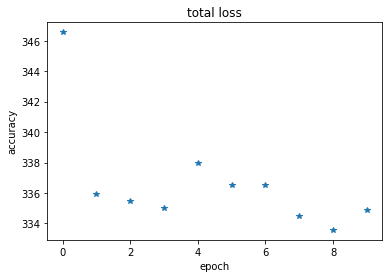

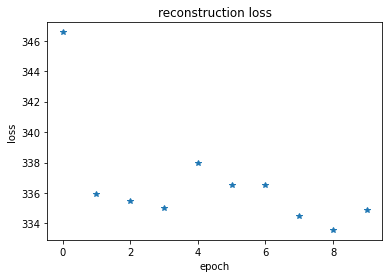

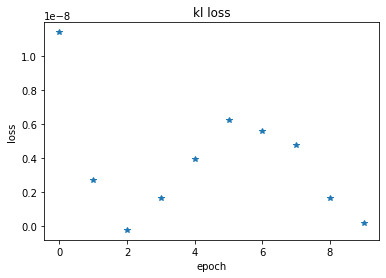

In [17]:
plt.plot(history.history['loss'],'*')
plt.title('total loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['reconstruction_loss'],'*')
plt.title('reconstruction loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['kl_loss'],'*')
plt.title('kl loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [19]:
encoder.save('models/betavae/encoder10.h5')

In [18]:
test_sets = ['test_easy_1.fa', 'test_easy_2.fa', 'test_intermidate_1.fa', 'test_intermidate_2.fa', 'test_difficult_1.fa', 
             'test_difficult_2.fa', 'test_very_difficult_1.fa', 'test_very_difficult_2.fa']
easy_1 = assign_labels(read_fasta(test_root + test_sets[0]))
easy_2 = assign_labels(read_fasta(test_root + test_sets[1]))

In [80]:
easy_1_predictions = encoder.predict(train_reads)

In [67]:
a = np.expand_dims(np.array(seqs2onehot([easy_1.loc[105487]['seqs']])), -1)
b = encoder.predict(a)
c = decoder.predict(b[-1]); c = np.squeeze(c)
difflib.SequenceMatcher(None, np.argmax((c>0.01), axis=1), np.argmax(np.squeeze(a), axis=1)).ratio()

In [87]:
np.array(b).shape

(3, 1, 16)